In [1]:
target_size = (256,256)
batch_size = 32
train_val_split = 0.2
num_classes = 5
nb_epochs =100
#init_epoch = 29
wandb_resume_state = True
exp_name = 'test2'

In [2]:
import shutil
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import save_model
import cv2
from tensorflow.keras.metrics import AUC, Precision, Recall
import wandb
from wandb.keras import WandbCallback

In [3]:
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
train_val_split = 0.2

In [5]:
#train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=train_val_split)
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split=train_val_split)
train_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/customdataset/Feature_Extraction', target_size = (256,256), batch_size = 20, class_mode = 'categorical', subset='training') 
validation_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/customdataset/Feature_Extraction', target_size = (256,256), batch_size = 20,  class_mode = 'categorical', subset='validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [6]:
labels = list(train_generator.class_indices.keys())

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all layers of the pre-trained model
for layer in resnet50.layers:
    layer.trainable = False

# Add new trainable fully connected layer on top of ResNet50
x = resnet50.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Combine pre-trained ResNet50 model with new layers
model = Model(inputs=resnet50.input, outputs=predictions)


94781440/94765736 [==============================] - 3s 0us/step


In [8]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy', Precision(),  Recall(), AUC()])


In [9]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping( patience=3, verbose=1)

In [10]:
history = model.fit(train_generator,steps_per_epoch = len(train_generator),
                          validation_data = validation_generator,
                          validation_steps =len( validation_generator),epochs = nb_epochs, callbacks=[early_stopping])

Epoch 1/100
147/147 [==============================] - 47s 243ms/step - loss: 5.9139 - accuracy: 0.6093 - precision: 0.6216 - recall: 0.6042 - auc: 0.8201 - val_loss: 1.1868 - val_accuracy: 0.6963 - val_precision: 0.7213 - val_recall: 0.6799 - val_auc: 0.8957
Epoch 2/100
147/147 [==============================] - 22s 149ms/step - loss: 1.4862 - accuracy: 0.6615 - precision: 0.6881 - recall: 0.6421 - auc: 0.8770 - val_loss: 0.9454 - val_accuracy: 0.7291 - val_precision: 0.7415 - val_recall: 0.7141 - val_auc: 0.9232
Epoch 3/100
147/147 [==============================] - 22s 151ms/step - loss: 1.0252 - accuracy: 0.6929 - precision: 0.7367 - recall: 0.6568 - auc: 0.9060 - val_loss: 0.9156 - val_accuracy: 0.7305 - val_precision: 0.7543 - val_recall: 0.7182 - val_auc: 0.9171
Epoch 4/100
147/147 [==============================] - 22s 147ms/step - loss: 0.8157 - accuracy: 0.7189 - precision: 0.7748 - recall: 0.6810 - auc: 0.9251 - val_loss: 0.8241 - val_accuracy: 0.7073 - val_precision: 0.7836

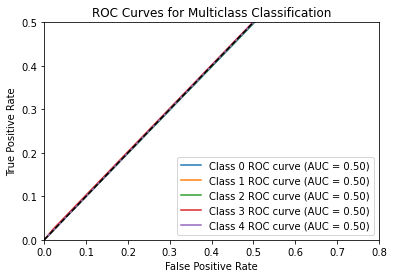

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error,mean_absolute_error
import numpy as np
# Make predictions for the test set
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)
y_true = validation_generator.classes

# Binarize the true labels and predictions
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))

# Compute the AUC for each class
aucs = []
for i in range(y_true_bin.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    auc = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
    aucs.append(auc)
    plt.plot(fpr, tpr, label='Class {} ROC curve (AUC = {:.2f})'.format(i, auc))

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 0.8])
plt.ylim([0.0, 0.5])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


In [12]:
y_true = np.argmax(y_true_bin, axis=1)
y_pred = np.argmax(y_pred_bin, axis=1)


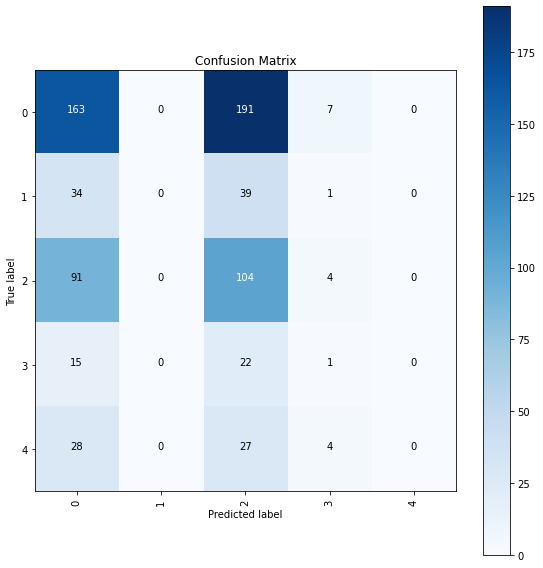

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Generate predictions for the test set
#y_pred = model.predict(validation_generator)
#y_pred = np.argmax(y_pred,axis=1)
#y_true = validation_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = validation_generator.class_indices.keys()

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [14]:
#save model
model_json = model.to_json()
with open('model_resnet50.json', 'w') as json_file:
    json_file.write(model_json)

model_saved = save_model(model, './weights.hdf5')
#load model
with open('model_resnet50.json', 'r') as json_file:
    json_saved_model = json_file.read()

model_loaded = tf.keras.models.model_from_json(json_saved_model)
model_loaded.load_weights('weights.hdf5')
model_loaded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#test single image
path = '/kaggle/input/traindata/train/3/0104b032c141.png'
image = cv2.imread(path)
image = cv2.resize(image, (256,256))
image = image/ 255    #normalise
#print(image.shape)
image = image.reshape(-1, 256,256,3)      #reshape in format to send more than one image to predict
#print(image.shape)

result = model_loaded(image)
#print(result)  #probabilities that the image belong to each class
result = np.argmax(result, axis=1)

if(result==0):
    print('Grade 0')
elif(result == 1):
    print('Grade 1')
elif(result == 2):
    print('Grade 2')
elif(result == 3):
    print('Grade 3')
else:
    print('Grade 4')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Grade 2


In [15]:
#train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=train_val_split)
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split=train_val_split)
r_train_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/redlesion-customdataset/RedLesion_CustomDataset', target_size = (256,256), batch_size = 20, class_mode = 'categorical', subset='training') 
r_validation_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/redlesion-customdataset/RedLesion_CustomDataset', target_size = (256,256), batch_size = 20,  class_mode = 'categorical', subset='validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [16]:
history = model.fit(r_train_generator,steps_per_epoch = len(r_train_generator),
                          validation_data = r_validation_generator,
                          validation_steps =len( r_validation_generator),epochs = nb_epochs ,callbacks=[early_stopping])

Epoch 1/100
147/147 [==============================] - 389s 3s/step - loss: 2.9013 - accuracy: 0.5803 - precision: 0.6043 - recall: 0.5534 - auc: 0.8157 - val_loss: 0.8616 - val_accuracy: 0.6990 - val_precision: 0.7931 - val_recall: 0.5663 - val_auc: 0.9137
Epoch 2/100
147/147 [==============================] - 361s 2s/step - loss: 0.6869 - accuracy: 0.7339 - precision: 0.8006 - recall: 0.6711 - auc: 0.9407 - val_loss: 0.7825 - val_accuracy: 0.7182 - val_precision: 0.7571 - val_recall: 0.6566 - val_auc: 0.9262
Epoch 3/100
147/147 [==============================] - 375s 3s/step - loss: 0.5381 - accuracy: 0.7844 - precision: 0.8346 - recall: 0.7298 - auc: 0.9631 - val_loss: 0.9693 - val_accuracy: 0.6785 - val_precision: 0.7270 - val_recall: 0.6265 - val_auc: 0.9080
Epoch 4/100
147/147 [==============================] - 350s 2s/step - loss: 0.4820 - accuracy: 0.8147 - precision: 0.8522 - recall: 0.7714 - auc: 0.9702 - val_loss: 0.8557 - val_accuracy: 0.7237 - val_precision: 0.7638 - val_r